# Analisis discursivo audiovisual

<h3><u>Grupo 2</u></h3>
- Lesertesseur, Diego <br/>
- Pelecchia, Franco <br/>
- Magariños, Néstor <br/>
- Suarez, Horacio E. 


<h3><u>Objetivos</u></h3>
El presente proyecto busca poner en manifiesto la factibilidad, escalabilidad y eficacia del análisis de streamings de video mediante herramientas de procesamiento de video, audio y texto. Para esto fueron utilizadas las señales de TN  y C5N, en la franja horaria de 19hs a 21hs y de 18hs a 20hs respectivamente. A continuación se mencionan las principales preguntas que busca responder el proyecto:  

- ¿Quién aparecio en la transmisión?
- ¿Cómo es la participación de género?
- ¿Cuáles fueron las personas más nombradas?
- ¿Qué tópicos se abordaron?
- ¿Con qué sentimiento fue abordado cada tópico?

<h3><u>Estructura</u></h3>
A fines de obtener un flujo de trabajo óptimo, el trabajo fue dividido en 3 notebooks:
- Preprocesamiento de video
- Preprocesamiento de audio
- Análisis de contenido (actual)

<a id="section_toc"></a> 
<h3><u>Tabla de contenidos</u></h3>

[1. Carga y preprocesamiento de datos](#section_1)  
&emsp; [1.1. Ventana temporal audio](#section_1_1)  
&emsp; [1.2. Ventana temporal video](#section_1_2)  
[2. Análisis de video](#section_2)  
&emsp; [2.1. Identificación de personas con más tiempo en pantalla](#section_2_1)  
&emsp; [2.2. Participación por género](#section_2_2)  
[3. Análisis de audio](#section_3)  
&emsp; [3.1. Name entity recognition](#section_3_1)  
&emsp; [3.2. Topic modeling](#section_3_2)  
&emsp; [3.3. Sentiment analysis](#section_3_3)  
[4. Resultados](#section_4)  
----
----

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import spacy
import unidecode
import re
import nltk
import squarify
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


----
----
<a id="section_1"></a> 
##  1. Carga y preprocesamiento de datos
[volver a TOC](#section_toc)

Los resultados del preprocesamiento de audio y video se encuentran expresados en distintas ventanas temporales, las cuales resulta necesario alinear para poder trabajar en paralelo. A lo largo de toda la Notebook se trabajará a nivel File y a nivel Delta, siendo File el contenido entero de programa captado (aproximadamente 2 horas) y Delta recortes de cada file de una duración determinada. 
En este caso, se ha optado por utilizar un Delta de 21 minutos

In [2]:
delta = 21
td = datetime.timedelta(minutes=delta)
print("Ventana temporal:",delta,"minutos")

Ventana temporal: 21 minutos


---
### 1.1 - Ventana temporal audio
<a id='section_1_1'></a>

In [3]:
audio_path = "../Data Procesada/data_audio.csv"
audio = pd.read_csv(audio_path)

audio.rename(columns={'folder':'fuente'},inplace=True)
audio.drop(columns=['Unnamed: 0','path_audio'],inplace=True)

audio['start'] = audio['start'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
audio['end'] = audio['end'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

print(audio.shape)
audio.head(3)

(1923, 6)


,fuente,file,date,text,start,end
0,C5N,C5N2020-08-15-17-00-45.wav,2020-08-15 17:00:45,grande bueno aun con el inefable en estos días...,2020-08-15 17:00:45,2020-08-15 17:01:27
1,C5N,C5N2020-08-15-17-00-45.wav,2020-08-15 17:00:45,hola hola cómo le va bienvenido buenas tardes ...,2020-08-15 17:01:59,2020-08-15 17:02:14
2,C5N,C5N2020-08-15-17-00-45.wav,2020-08-15 17:00:45,visto y abrazo grande desde acá de todo el equ...,2020-08-15 17:02:15,2020-08-15 17:03:00


In [4]:
registrosAudio =  pd.DataFrame(columns=['fuente', 'file','deltaStart', 'deltaEnd','textDelta'])

for file in audio['file'].unique():
    
    maskFile =  audio['file'] == file
    
    fuente = audio.loc[maskFile, 'fuente'].unique()
    
    deltaStart = audio.loc[maskFile, 'start'].min()
    deltaEnd = deltaStart + td
    
    endFile = audio.loc[maskFile, 'end'].max()
    n_delta=1
    while deltaStart <= endFile:
        
        maskDelta = (audio['start'] >= deltaStart) & (audio['end'] < deltaEnd)
        
        audio.loc[maskDelta & maskFile,'deltaStart'] = deltaStart
        
        audio.loc[maskDelta & maskFile,'deltaEnd'] = deltaEnd

        text = audio.loc[maskDelta & maskFile,'text'].unique()
        textDelta = ','.join(text)
        newInput=pd.DataFrame([textDelta], columns=['textDelta'])
        newInput['words_counts'] = [len(x.split()) for x in newInput['textDelta'].tolist()]
        newInput['file'] = file
        newInput['fuente'] = fuente
        newInput['deltaStart'] = deltaStart
        newInput['deltaEnd'] = deltaEnd
        newInput['deltaStep'] = n_delta
        newInput.reset_index(inplace=True)
        
        registrosAudio = registrosAudio.append(newInput)
        n_delta=n_delta+1
        deltaStart = deltaStart + td
        deltaEnd = deltaStart + td
        
registrosAudio['file'] = registrosAudio['file'].apply(lambda x: x.split('.')[0]) 
registrosAudio['deltaStep'] = registrosAudio['deltaStep'].apply(lambda x: int(x))
registrosAudio.reset_index(drop=True,inplace=True)
registrosAudio=registrosAudio[['fuente', 'file','deltaStep',  'deltaStart', 'deltaEnd', 'textDelta','words_counts']]

print(registrosAudio.shape)
registrosAudio.head(10)

(75, 7)


,fuente,file,deltaStep,deltaStart,deltaEnd,textDelta,words_counts
0,C5N,C5N2020-08-15-17-00-45,1,2020-08-15 17:00:45,2020-08-15 17:21:45,grande bueno aun con el inefable en estos días...,2791.0
1,C5N,C5N2020-08-15-17-00-45,2,2020-08-15 17:21:45,2020-08-15 17:42:45,por eso esto que pasa en barcelona era impensa...,3169.0
2,C5N,C5N2020-08-15-17-00-45,3,2020-08-15 17:42:45,2020-08-15 18:03:45,las nueve de la mañana diez para tres de la ma...,2467.0
3,C5N,C5N2020-08-15-17-00-45,4,2020-08-15 18:03:45,2020-08-15 18:24:45,más en el caso del fútbol a diferencia de otro...,1648.0
4,C5N,C5N2020-08-15-17-00-45,5,2020-08-15 18:24:45,2020-08-15 18:45:45,bueno ahora trabaja más pero siempre está pres...,2385.0
5,C5N,C5N2020-08-15-17-00-45,6,2020-08-15 18:45:45,2020-08-15 19:06:45,alguna según este estudio que se hizo tienen q...,2695.0
6,C5N,C5N2020-08-15-17-00-45,7,2020-08-15 19:06:45,2020-08-15 19:27:45,y ese ministerio tiene una dirección en salud ...,2332.0
7,C5N,C5N2020-08-15-17-00-45,8,2020-08-15 19:27:45,2020-08-15 19:48:45,la puso a trujillo ahora miguel el aire decidí...,3088.0
8,C5N,C5N2020-08-15-17-00-45,9,2020-08-15 19:48:45,2020-08-15 20:09:45,líbano y así de esta manera poder ayudar esta ...,2644.0
9,C5N,C5N2020-08-15-17-00-45,10,2020-08-15 20:09:45,2020-08-15 20:30:45,es casi haría como como hacia el papa distinto...,1899.0


---
### 1.2 - Ventana temporal video
<a id='section_1_2'></a>

El resultado del preprocesamiento de video otorga un datasets en los que cada fila es la aparecición de una persona en un determinado segundo, pudiendo ser posible que para un mismo segundo haya más de un personaje o no haya ninguno.

Las personas etiquetadas con el prefijo "c_" son conductores.

In [5]:
videoTablePath = "../Data procesada/TablasVideo/"

video = pd.DataFrame()
for videoTable in os.listdir(videoTablePath):
    registro = pd.read_csv(videoTablePath + videoTable)
    video = pd.concat([video, registro])

video['file'] = video['file'].apply(lambda x: x if x is np.NaN else x.split('.')[0])
video['datetime'] = video['fecha_hora'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
video = video[['fuente', 'file', 'datetime','personaje', 'genero']]

print(video.shape)
video.sample(5)

(112713, 5)


,fuente,file,datetime,personaje,genero
7120,TN,TN2020-08-17-19-00-08,2020-08-17 20:19:09,NO IDENTIFICADO,M
6651,TN,TN2020-08-17-19-00-08,2020-08-17 20:14:29,hugo_sigman,M
3853,TN,TN2020-08-17-19-00-08,2020-08-17 19:44:22,SIN PERSONAS IDENTIFICABLES,NaN
7751,C5N,C5N2020-08-15-17-00-45,2020-08-15 18:49:44,SIN PERSONAS IDENTIFICABLES,NaN
4891,TN,TN2020-08-18-19-00-19,2020-08-18 19:59:28,luis_naidenoff,M


Aplicamos una corrección de géneros mal tageados y unificamos nombres de personas que tenian más de una imagen en el proceso de reconocimiento de video

In [6]:
GeneroEquivocado = ["c_julian_guarino", "c_pablo_duggan", "miguel_angel_pichetto", "christian_castillo", "diego_santilli",\
                    "diego_santilli_2", "victor_hugo_morales", "gines_gonzalez_garcia", "santiago_teran", "c_gustavo_tubio",\
                    "c_gustavo_tubio", "soledad_acuna", "alexia_peralta","c_elio_rossi","axel_kicillof",\
                    "lionel_messi","c_alejandra_malem"]

mask_InvertirGenero = video['personaje'].isin(GeneroEquivocado)
video.loc[mask_InvertirGenero,'genero']= video.loc[mask_InvertirGenero,'genero'].apply(lambda x: 'M' if x=='F' else 'F')

In [7]:
video['personaje']= video['personaje'].apply(lambda x: x.replace("_1",''))
video['personaje']= video['personaje'].apply(lambda x: x.replace("_2",''))
video['personaje']= video['personaje'].apply(lambda x: x.replace("_3",''))
video['personaje']= video['personaje'].apply(lambda x: x.replace("_4",''))

In [8]:
registrosVideo =  pd.DataFrame()

for file in video['file'].unique():
    
    maskFile =  video['file'] == file
    
    deltaStart = video.loc[maskFile, 'datetime'].min()
    deltaEnd = deltaStart + td
    
    endFile = video.loc[maskFile, 'datetime'].max()
    n_delta=1    
    while deltaStart <= endFile:
        
        
        maskDelta = (video['datetime'] >= deltaStart) & (video['datetime'] < deltaEnd)
        
        video.loc[maskDelta & maskFile,'deltaStart'] = deltaStart
        
        video.loc[maskDelta & maskFile,'deltaEnd'] = deltaEnd
        
        newInput = video.loc[maskDelta & maskFile, ['deltaStart', 'deltaEnd', 'file','fuente','personaje','genero']]
        newInput = newInput.groupby(['deltaStart', 'deltaEnd', 'file','fuente','genero'])['personaje'].value_counts()
        
        
        newInput = pd.DataFrame(newInput)
        newInput.rename(columns={'personaje':'segundos'},inplace=True)
        newInput['deltaStep'] = n_delta
        newInput.reset_index(inplace=True)
        
        registrosVideo = registrosVideo.append(newInput)
        n_delta=n_delta+1
        deltaStart = deltaStart + td
        deltaEnd = deltaStart + td

registrosVideo=registrosVideo[['fuente','file', 'deltaStep','deltaStart', 'deltaEnd', 'personaje','genero','segundos']]
registrosVideo

,fuente,file,deltaStep,deltaStart,deltaEnd,personaje,genero,segundos
0,C5N,C5N2020-08-14-17-55-49,1,2020-08-14 17:55:49,2020-08-14 18:16:49,NO IDENTIFICADO,F,57
1,C5N,C5N2020-08-14-17-55-49,1,2020-08-14 17:55:49,2020-08-14 18:16:49,patricia_bullrich,F,4
2,C5N,C5N2020-08-14-17-55-49,1,2020-08-14 17:55:49,2020-08-14 18:16:49,liilta_carrio,F,3
3,C5N,C5N2020-08-14-17-55-49,1,2020-08-14 17:55:49,2020-08-14 18:16:49,graciela_ciccia,F,2
4,C5N,C5N2020-08-14-17-55-49,1,2020-08-14 17:55:49,2020-08-14 18:16:49,c_dominique_metzger,F,1
...,...,...,...,...,...,...,...,...
23,TN,TN2020-08-25-18-59-36,6,2020-08-25 20:44:36,2020-08-25 21:05:36,eduardo_duhalde,M,1
24,TN,TN2020-08-25-18-59-36,6,2020-08-25 20:44:36,2020-08-25 21:05:36,gerard_pique,M,1
25,TN,TN2020-08-25-18-59-36,6,2020-08-25 20:44:36,2020-08-25 21:05:36,horacio_rodriguez_larreta,M,1
26,TN,TN2020-08-25-18-59-36,6,2020-08-25 20:44:36,2020-08-25 21:05:36,nelson_castro,M,1


---
---
<a id="section_2"></a> 
##  2. Análisis de video
[volver a TOC](#section_toc)

### 2.1. Identificación de personas con más tiempo en pantalla
<a id='section_2_1'></a>
Para este análisis no son tenidos en cuenta los conductores ni las personas no identificadas

In [9]:
mask_NoConductores = registrosVideo['personaje'].apply(lambda x: 'c_' not in x)
mask_NoIdentificados = registrosVideo['personaje'] !=  'NO IDENTIFICADO'
mask_SinPersonas = registrosVideo['personaje'] !=  'SIN PERSONAS IDENTIFICABLES'
mask_final = mask_NoConductores & mask_NoIdentificados & mask_SinPersonas

In [10]:
registrosVideo_PersonasFile = registrosVideo.loc[mask_final, ['file','personaje','genero','segundos']]
registrosVideo_PersonasFile = pd.DataFrame(registrosVideo_PersonasFile.groupby(['file','genero','personaje'])['segundos'].sum()).reset_index()
registrosVideo_PersonasFile = registrosVideo_PersonasFile.sort_values(by=['file','genero','segundos'],ascending=False)
registrosVideo_PersonasFile['personaje']= registrosVideo_PersonasFile['personaje'].apply(lambda x: x.replace("_",' ') )
registrosVideo_PersonasFile=registrosVideo_PersonasFile[['file','personaje','genero','segundos']]
registrosVideo_PersonasFile.head()

,file,personaje,genero,segundos
333,TN2020-08-25-18-59-36,sergio berensztein,M,326
328,TN2020-08-25-18-59-36,matias posada,M,170
322,TN2020-08-25-18-59-36,jorge lanata,M,120
321,TN2020-08-25-18-59-36,hugo sigman,M,36
324,TN2020-08-25-18-59-36,lionel messi,M,26


In [11]:
registrosVideo_PersonasDelta = registrosVideo.loc[mask_final, ['file','deltaStep','personaje','genero','segundos']]
registrosVideo_PersonasDelta = pd.DataFrame(registrosVideo_PersonasDelta.groupby(['file','deltaStep','genero','personaje'])['segundos'].sum()).reset_index()
registrosVideo_PersonasDelta = registrosVideo_PersonasDelta.sort_values(by=['file','deltaStep','genero','segundos'],ascending=False)
registrosVideo_PersonasDelta['personaje']= registrosVideo_PersonasDelta['personaje'].apply(lambda x: x.replace("_",' ') )
registrosVideo_PersonasDelta.head()

,file,deltaStep,genero,personaje,segundos
995,TN2020-08-25-18-59-36,6,M,matias posada,165
993,TN2020-08-25-18-59-36,6,M,lionel messi,25
996,TN2020-08-25-18-59-36,6,M,miguel angel pichetto,7
991,TN2020-08-25-18-59-36,6,M,hernan lombardi,6
994,TN2020-08-25-18-59-36,6,M,luis naidenoff,2


---
### 2.2. Participación por género
<a id='section_2_2'></a>
El análisis de participación de género es realizado para el total de personas y, en particular, para los conductores

In [12]:
registrosVideo_GeneroFile = registrosVideo.loc[:, ['file','genero','segundos']]
registrosVideo_GeneroFile = pd.DataFrame(registrosVideo_GeneroFile.groupby(['file','genero'])['segundos'].sum()).reset_index()
registrosVideo_GeneroFile = registrosVideo_GeneroFile.sort_values(by=['file','segundos'],ascending=False)

segundosPorFile = pd.DataFrame(registrosVideo_GeneroFile.groupby(['file'])['segundos'].sum())
segundosPorFile.reset_index(inplace=True)
registrosVideo_GeneroFile=registrosVideo_GeneroFile.merge(segundosPorFile,on='file',suffixes=('','_total'))
registrosVideo_GeneroFile['segundos pct']= round(100*registrosVideo_GeneroFile['segundos']/registrosVideo_GeneroFile['segundos_total'],ndigits=1)
registrosVideo_GeneroFile.drop(columns=['segundos_total'],inplace=True)

display(registrosVideo_GeneroFile.iloc[0:6,:])
display(registrosVideo_GeneroFile.iloc[10:16,:])

,file,genero,segundos,segundos pct
0,TN2020-08-25-18-59-36,M,5212,83.0
1,TN2020-08-25-18-59-36,F,1071,17.0
2,TN2020-08-18-19-00-19,M,4878,63.3
3,TN2020-08-18-19-00-19,F,2823,36.7
4,TN2020-08-17-19-00-08,M,6899,88.4
5,TN2020-08-17-19-00-08,F,907,11.6


,file,genero,segundos,segundos pct
10,C5N2020-08-25-17-55-42,M,6209,91.2
11,C5N2020-08-25-17-55-42,F,599,8.8
12,C5N2020-08-18-17-57-53,M,7115,89.3
13,C5N2020-08-18-17-57-53,F,855,10.7
14,C5N2020-08-17-17-54-34,M,3965,89.4
15,C5N2020-08-17-17-54-34,F,471,10.6


In [13]:
mask_Conductores = registrosVideo['personaje'].apply(lambda x: 'c_' in x)

registrosVideo_GeneroConductoresFile = registrosVideo.loc[mask_final, ['file','genero','segundos']]
registrosVideo_GeneroConductoresFile = pd.DataFrame(registrosVideo_GeneroConductoresFile.groupby(['file','genero'])['segundos'].sum()).reset_index()
registrosVideo_GeneroConductoresFile = registrosVideo_GeneroConductoresFile.sort_values(by=['file','segundos'],ascending=False)

segundosPorFile = pd.DataFrame(registrosVideo_GeneroConductoresFile.groupby(['file'])['segundos'].sum())
segundosPorFile.reset_index(inplace=True)
registrosVideo_GeneroConductoresFile=registrosVideo_GeneroConductoresFile.merge(segundosPorFile,on='file',suffixes=('','_total'))
registrosVideo_GeneroConductoresFile['segundos pct']= round(100*registrosVideo_GeneroConductoresFile['segundos']/registrosVideo_GeneroConductoresFile['segundos_total'],ndigits=1)
registrosVideo_GeneroConductoresFile.drop(columns=['segundos_total'],inplace=True)


display(registrosVideo_GeneroConductoresFile.iloc[0:6,:])
display(registrosVideo_GeneroConductoresFile.iloc[10:16,:])

,file,genero,segundos,segundos pct
0,TN2020-08-25-18-59-36,M,816,83.4
1,TN2020-08-25-18-59-36,F,162,16.6
2,TN2020-08-18-19-00-19,F,1207,50.3
3,TN2020-08-18-19-00-19,M,1194,49.7
4,TN2020-08-17-19-00-08,M,3013,82.5
5,TN2020-08-17-19-00-08,F,640,17.5


,file,genero,segundos,segundos pct
10,C5N2020-08-25-17-55-42,M,2055,93.9
11,C5N2020-08-25-17-55-42,F,134,6.1
12,C5N2020-08-18-17-57-53,M,2017,86.7
13,C5N2020-08-18-17-57-53,F,309,13.3
14,C5N2020-08-17-17-54-34,M,2002,98.1
15,C5N2020-08-17-17-54-34,F,38,1.9


In [14]:
registrosVideo_GeneroDelta = registrosVideo.loc[:, ['file','genero','deltaStep','segundos']]
registrosVideo_GeneroDelta = pd.DataFrame(registrosVideo_GeneroDelta.groupby(['file','genero','deltaStep',])['segundos'].sum()).reset_index()
registrosVideo_GeneroDelta = registrosVideo_GeneroDelta.sort_values(by=['file','deltaStep','segundos'],ascending=False)

segundosPorFile = pd.DataFrame(registrosVideo_GeneroDelta.groupby(['file','deltaStep'])['segundos'].sum())
segundosPorFile.reset_index(inplace=True)
registrosVideo_GeneroDelta=registrosVideo_GeneroDelta.merge(segundosPorFile,on=['file','deltaStep'],suffixes=('','_total'))
registrosVideo_GeneroDelta['segundos pct']= round(100*registrosVideo_GeneroDelta['segundos']/registrosVideo_GeneroDelta['segundos_total'],ndigits=1)
registrosVideo_GeneroDelta.drop(columns=['segundos_total'],inplace=True)


registrosVideo_GeneroDelta.head(6)

,file,genero,deltaStep,segundos,segundos pct
0,TN2020-08-25-18-59-36,M,6,693,85.6
1,TN2020-08-25-18-59-36,F,6,117,14.4
2,TN2020-08-25-18-59-36,M,5,973,84.5
3,TN2020-08-25-18-59-36,F,5,179,15.5
4,TN2020-08-25-18-59-36,M,4,1078,82.7
5,TN2020-08-25-18-59-36,F,4,225,17.3


In [15]:
mask_Conductores = registrosVideo['personaje'].apply(lambda x: 'c_' in x)

registrosVideo_GeneroConductoresDelta = registrosVideo.loc[mask_final, ['file','genero','deltaStep','segundos']]
registrosVideo_GeneroConductoresDelta = pd.DataFrame(registrosVideo_GeneroConductoresDelta.groupby(['file','genero','deltaStep',])['segundos'].sum()).reset_index()
registrosVideo_GeneroConductoresDelta = registrosVideo_GeneroConductoresDelta.sort_values(by=['file','deltaStep','segundos'],ascending=False)

segundosPorFile = pd.DataFrame(registrosVideo_GeneroConductoresDelta.groupby(['file','deltaStep'])['segundos'].sum())
segundosPorFile.reset_index(inplace=True)
registrosVideo_GeneroConductoresDelta=registrosVideo_GeneroConductoresDelta.merge(segundosPorFile,on=['file','deltaStep'],suffixes=('','_total'))
registrosVideo_GeneroConductoresDelta['segundos pct']= round(100*registrosVideo_GeneroConductoresDelta['segundos']/registrosVideo_GeneroConductoresDelta['segundos_total'],ndigits=1)
registrosVideo_GeneroConductoresDelta.drop(columns=['segundos_total'],inplace=True)

registrosVideo_GeneroConductoresDelta.head(6)

,file,genero,deltaStep,segundos,segundos pct
0,TN2020-08-25-18-59-36,M,6,212,97.7
1,TN2020-08-25-18-59-36,F,6,5,2.3
2,TN2020-08-25-18-59-36,M,5,233,96.7
3,TN2020-08-25-18-59-36,F,5,8,3.3
4,TN2020-08-25-18-59-36,M,4,171,91.4
5,TN2020-08-25-18-59-36,F,4,16,8.6


----
----
<a id="section_3"></a> 
##  3. Análisis de audio
[volver a TOC](#section_toc)
### 3.1. Name entity recognition
<a id='section_3_1'></a>

In [16]:
def LabelsLG(text):
    lgLoad = spacy.load("es_core_news_lg")
    entities = []
    labels = []
    df = pd.DataFrame([], columns=["Entities", 'Labels'])
    trainedText = lgLoad(text)
    
    for ent in trainedText.ents:
        entities.append(ent)
        labels.append(ent.label_)
        df = pd.concat([df,pd.DataFrame({'Entities':entities,'Labels':labels})])        
    df["textEntities"] = df.Entities.apply(lambda x : x.text)
    return df


def GetPersonsCount (text):
    df = LabelsLG(text)
    return df.textEntities[df.Labels=="PER"].value_counts()


def AddPerson (dataFrame,seriePerson):   
    for person in seriePerson.index:
        if not person in dataFrame.columns:
            dataFrame[person] = 0
            
    return dataFrame


def AddEmptyRow (dataFrame):   
    newRow = pd.DataFrame([[0] * dataFrame.shape[1]], columns=dataFrame.columns)
    dataFrame = pd.concat([dataFrame, newRow], ignore_index=True)
    
    return dataFrame
  
    
def AddContent (dataFrame, text, file, deltaStep):

    personCount =  GetPersonsCount (text)

    dataFrame = AddPerson (dataFrame,personCount)

    dataFrame = AddEmptyRow(dataFrame)

    dataFrame.loc[dataFrame.index[-1],"text"] = text
    dataFrame.loc[dataFrame.index[-1],"file"] = file
    dataFrame.loc[dataFrame.index[-1],"deltaStep"] = deltaStep
    
    for person in personCount.index:
        dataFrame.iloc[-1, dataFrame.columns.get_loc(person)] = personCount[person]
    return dataFrame

def DataFrameGenerator (DataFrame, textChannelSeries):       
    for row in textChannelSeries.index:
        DataFrame = AddContent(DataFrame,textChannelSeries.textDelta[row], textChannelSeries.file[row],textChannelSeries.deltaStep[row])
    
    return DataFrame

def SortDataFrame (dataFrame):
    sums = dataFrame.sum()
    return dataFrame[sums.sort_values(ascending=False).index] 

In [17]:
dataFrameEmpty = pd.DataFrame([], columns = ["file","text",'deltaStep'])
texts = registrosAudio[['file','textDelta','deltaStep']]
dataFrameFinal = DataFrameGenerator(dataFrameEmpty, texts)
dataFrameFinal.head()

,file,text,deltaStep,sáenz,alberto fernández,matías,néstor de ir,messi,hola hola,pablito,...,néstor kirchner carlos kirchner,roberto barata,roberto saviano libros,roxana carvajal,roxana caravana,roxana,maría del carmen saavedra,zamora,carvajal roxana,facundo estudio
0,C5N2020-08-15-17-00-45,grande bueno aun con el inefable en estos días...,1,207,169,158,71,70,70,69,...,0,0,0,0,0,0,0,0,0,0
1,C5N2020-08-15-17-00-45,por eso esto que pasa en barcelona era impensa...,2,0,0,0,0,932,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C5N2020-08-15-17-00-45,las nueve de la mañana diez para tres de la ma...,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C5N2020-08-15-17-00-45,más en el caso del fútbol a diferencia de otro...,4,0,0,0,0,101,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C5N2020-08-15-17-00-45,bueno ahora trabaja más pero siempre está pres...,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
def NameInNames(name, names):
    position = 0
    condition = False
    while (not condition) and (position<len(names)):
        condition = (name in names[position]) and (name != names[position]) 
        position = position + 1
    return condition
def GetBestMatch (name, dataFrame):
    nameMask = dataFrame.personaje.apply(lambda x : name in x)
    bestMatch = dataFrame[nameMask].sort_values(by= "menciones", ascending = False).personaje.iloc[0]
    return bestMatch
def UnifyAndDelete (name, dataFrame):
    nameMask = dataFrame.personaje.apply(lambda x : name in x)
    bestMatch = GetBestMatch(name, dataFrame)
    total = dataFrame[nameMask].menciones.sum()
    dataFrame.loc[dataFrame[dataFrame.personaje == bestMatch].index, "menciones"] = total
    dataFrame.drop(dataFrame[np.logical_and(nameMask,dataFrame.personaje != bestMatch)].index, inplace  = True)
    return dataFrame
def NamesUnifier (dataFrame):
    names = dataFrame.personaje
    for name in names:
        if NameInNames(name,dataFrame.personaje.values):
            dataFrame = UnifyAndDelete(name, dataFrame)
    return dataFrame

In [19]:
NER = pd.melt(dataFrameFinal, value_vars=dataFrameFinal.drop(columns=["file","text",'deltaStep']).columns.values, id_vars=["file",'deltaStep'] )
NER.rename(columns={'value':'menciones','variable':'personaje'},inplace=True)
NERFile2 = pd.DataFrame(NER.groupby(["file",'personaje'])['menciones'].sum()).reset_index()
NERFile2 = NERFile2.sort_values(by=['file','menciones'],ascending=False)


NERFile = pd.DataFrame()
for file in NERFile2['file'].unique():
    mask_file = NERFile2['file'] == file
    newInput = NamesUnifier(NERFile2.loc[mask_file,:]);
    NERFile = pd.concat([NERFile,newInput])
    
NERFile = NERFile.sort_values(by=['file','menciones'], ascending = False)
NERFile

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,file,personaje,menciones
9691,TN2020-08-25-18-59-36,macri,1193
9111,TN2020-08-25-18-59-36,alberto fernández,1076
9351,TN2020-08-25-18-59-36,duhalde,916
9286,TN2020-08-25-18-59-36,cristina kirchner,767
9434,TN2020-08-25-18-59-36,franco,612
...,...,...,...
1005,C5N2020-08-14-17-55-49,yacom,0
1006,C5N2020-08-14-17-55-49,young general,0
1007,C5N2020-08-14-17-55-49,zamora,0
1008,C5N2020-08-14-17-55-49,zúrich suiza,0


In [20]:
NERDelta2 = NER.sort_values(by=['file','deltaStep','menciones'],ascending=False)

NERDelta = pd.DataFrame()
for file in NERDelta2['file'].unique():
    mask_file = NERDelta2['file'] == file
    for step in NERDelta2.loc[mask_file,'deltaStep'].unique():
        mask_step = NERDelta2['deltaStep'] == step
        mask_fileStep = mask_file & mask_step        
        newInput = NamesUnifier(NERDelta2.loc[mask_fileStep,:]);
        NERDelta = pd.concat([NERDelta,newInput])
    
NERDelta = NERDelta.sort_values(by=['file','deltaStep','menciones'], ascending = False)
NERDelta

C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,file,deltaStep,personaje,menciones
62912,TN2020-08-25-18-59-36,6,martín gonzález,199
56837,TN2020-08-25-18-59-36,6,franco,184
362,TN2020-08-25-18-59-36,6,messi,161
53912,TN2020-08-25-18-59-36,6,nico,148
63287,TN2020-08-25-18-59-36,6,facundo municipio,129
...,...,...,...,...
74732,C5N2020-08-14-17-55-49,1,pillo,0
74807,C5N2020-08-14-17-55-49,1,ramo verde,0
74882,C5N2020-08-14-17-55-49,1,delia majete,0
74957,C5N2020-08-14-17-55-49,1,gal primo,0


---
### 3.2. Topic modeling
<a id='section_3_2'></a>

Definimos el conjunto de stopwords a utilizar y le aplicamos stemming.

In [21]:
stopwords_sp_1 = pd.DataFrame(stopwords.words('spanish'),columns=["stopwords"])
stopwords_sp_2 = pd.read_csv("../Varios/stopwords.txt",header=None,names=["stopwords"]) #https://countwordsfree.com/stopwords/spanish/txt
stopwords_sp_3 = stopwords_sp_2.append(stopwords_sp_1)

stopwords_sp = []
for word in stopwords_sp_3.values:
    word_clean =  unidecode.unidecode(str(word[0]).lower())
    if word_clean not in stopwords_sp:
        stopwords_sp.append(word_clean)
        
print("Stopwords:",len(stopwords_sp))

Stopwords: 591


In [22]:
def stemfraseesp_for_stopwords(frase):    
    token_words=word_tokenize(frase)
    stem_sentence=[]    
    spanishStemmer=SnowballStemmer("spanish")
    for word in token_words:
        stem_sentence.append(spanishStemmer.stem(word))
    return "".join(stem_sentence)

In [23]:
stopwords_sp_stemming = []
for word in stopwords_sp:
    stopword_stem = stemfraseesp_for_stopwords(word)
    if stopword_stem not in stopwords_sp_stemming:
        stopwords_sp_stemming.append(stopword_stem)

print("Stopwords con stemming:",len(stopwords_sp_stemming))

Stopwords con stemming: 369


Creamos una tabla que nos permita conservar cuál es la palabra origina de cada stemming para que luego de contar las palabras podamos transformarla en su forma original. Aquellos stemmings que coincidan para más de una palabra, conservarán la palabra que más veces aparecio para su conversión a la forma original.

In [24]:
personas = registrosVideo['personaje'].drop_duplicates()
personas = [x.replace("c_",'') for x in personas if x!="NO IDENTIFICADO"]
personas = [x.replace("_",' ') for x in personas]
personas_apellidos = [x.split(" ")[-1] for x in personas]

In [25]:
texto_completo = "".join(registrosAudio['textDelta'])
texto_completo=unidecode.unidecode(texto_completo.lower())
texto_completo=re.sub(r'([^\s\w]|_)+','',texto_completo)

token_words=word_tokenize(texto_completo)
stem_sentence=[]    
token_words_clean=[]
spanishStemmer=SnowballStemmer("spanish")

for word in token_words:
    if word in personas_apellidos:
        stem_sentence.append(word)
        token_words_clean.append(word)        
    else:
        if len(word)>2:
            word_stem = spanishStemmer.stem(word)
            if word_stem not in stopwords_sp_stemming:
                stem_sentence.append(word_stem)
                token_words_clean.append(word)

In [26]:
stem_match = pd.DataFrame([token_words_clean,stem_sentence],index=['original','stem']).T
stem_match =  pd.DataFrame(stem_match.groupby('stem')['original'].value_counts())
stem_match.columns = ['count']
stem_match.reset_index(inplace=True)

stem_match = stem_match.sort_values(by='count', ascending=False)
stem_match.drop_duplicates(subset=['stem'],keep='first', inplace=True)
stem_match.reset_index(drop=True,inplace=True)

print(stem_match.shape)
stem_match.head()

(8831, 3)


,stem,original,count
0,gent,gente,516
1,gobiern,gobierno,386
2,dia,dia,345
3,argentin,argentina,341
4,mil,mil,244


Realizamos el stemming para el contenido por File y Delta


In [27]:
def stemfraseesp(frase):    
    token_words=word_tokenize(frase)
    stem_sentence=[]    
    token_words_clean=[]
    spanishStemmer=SnowballStemmer("spanish")
    for word in token_words:
        if word in personas_apellidos:
            stem_sentence.append(word)  
            stem_sentence.append(" ")
        else:
            if len(word)>2:
                word_stem = spanishStemmer.stem(word)
                if word_stem not in stopwords_sp_stemming:
                    stem_sentence.append(word_stem)
                    stem_sentence.append(" ")
    return "".join(stem_sentence)

In [28]:
auxiliar = registrosAudio.loc[:,['file','textDelta']]

textos=[]
files=[]
for file in auxiliar['file'].unique():
    mask=auxiliar['file']==file
    newInput= ' '.join(auxiliar.loc[mask,'textDelta'])
    textos.append(newInput)
    files.append(file)
    
textos_limpios=[];
for t in textos:
    t_lower_no_accents=unidecode.unidecode(t.lower()); 
    t_lower_no_accents_no_punkt=re.sub(r'([^\s\w]|_)+','',t_lower_no_accents); 
    textos_limpios.append(t_lower_no_accents_no_punkt)
    
textos_finalFile = []
for t in textos_limpios:
    textos_finalFile.append(stemfraseesp(t))

In [29]:
textos = registrosAudio.loc[:,'textDelta']

textos_limpios=[];
for t in textos:
    t_lower_no_accents=unidecode.unidecode(t.lower()); 
    t_lower_no_accents_no_punkt=re.sub(r'([^\s\w]|_)+','',t_lower_no_accents); 
    textos_limpios.append(t_lower_no_accents_no_punkt)
    
textos_finalDelta = []
for t in textos_limpios:
    textos_finalDelta.append(stemfraseesp(t))

Utilizamos Term Frequency Inverse Document Frequency (TF-IDF) para encontrar los tópicos

In [30]:
cantidad_de_topicos=10

In [31]:
vectorizerFile=CountVectorizer(stop_words=stopwords_sp,lowercase=True,ngram_range=(1,1), max_df=0.9); 
vectorizerFile.fit(textos_finalFile);

features_names_original = pd.DataFrame(vectorizerFile.get_feature_names(),columns=['word'])
features_namesFile= features_names_original.merge(stem_match, how='left',left_on='word',right_on='stem')['original']

CV_encodingFile=vectorizerFile.transform(textos_finalFile);

Tfidf_encodingFile=TfidfTransformer().fit_transform(CV_encodingFile);
#pd.DataFrame(Tfidf_encodingFile.todense(),columns=features_namesFile,index=registrosAudio['file'].unique()).head()

In [32]:
tfidf_File = pd.DataFrame(Tfidf_encodingFile.todense(),columns=features_namesFile)
tfidf_File.index = auxiliar['file'].unique()
tfidf_File= tfidf_File.T

topicos = []
for x in tfidf_File.columns:
    topico_x = tfidf_File[x].sort_values(ascending=False)[0:cantidad_de_topicos].index
    topico_x = [str(x) for x in topico_x]
    topico_x = ' '.join(topico_x)
    rank_x = tfidf_File[x].sort_values(ascending=False)[0:cantidad_de_topicos].round(2).values
    topicos.append([x,topico_x,rank_x])

topicosFile = pd.DataFrame(topicos,columns=['file','topico','rank'])
pd.set_option('display.max_colwidth', 100)
topicosFile

,file,topico,rank
0,C5N2020-08-15-17-00-45,barcelona tortilla jugadores entrenar futbol clubes cloro ariel dioxido actividad,"[0.23, 0.18, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.11]"
1,C5N2020-08-17-17-54-34,rafa violento miley libertad obelisco vacuna tira huevos derecho reforma,"[0.24, 0.23, 0.17, 0.16, 0.14, 0.14, 0.14, 0.13, 0.12, 0.12]"
2,C5N2020-08-25-17-55-42,duhalde golpe militar clarin cuba eduardo facundo causa medicamentos pablo,"[0.62, 0.19, 0.16, 0.14, 0.13, 0.12, 0.1, 0.09, 0.08, 0.08]"
3,C5N2020-08-18-17-57-53,macri venezuela reforma brandon trump pablo democracia aburrida mauricio pro,"[0.25, 0.19, 0.15, 0.15, 0.15, 0.13, 0.12, 0.12, 0.11, 0.11]"
4,C5N2020-08-14-17-55-49,vacuna nino libertad espana terapia definiciones colapso pablo avenida fraude,"[0.24, 0.17, 0.14, 0.14, 0.12, 0.12, 0.1, 0.1, 0.09, 0.09]"
5,TN2020-08-15-16-30-30,nino plaza cloro dioxido temperatura isidro grados sustancia noche barcelona,"[0.26, 0.15, 0.14, 0.14, 0.13, 0.12, 0.12, 0.12, 0.11, 0.1]"
6,TN2020-08-17-19-00-08,reforma oposicion judicial dirigentes entendeis movilizacion cristina libertades argumento inter...,"[0.27, 0.17, 0.14, 0.12, 0.12, 0.1, 0.1, 0.1, 0.09, 0.09]"
7,TN2020-08-25-18-59-36,duhalde cuerpo reforma perito casinos salvador municipalidad chubut forense especialistas,"[0.24, 0.2, 0.18, 0.18, 0.15, 0.14, 0.13, 0.12, 0.12, 0.11]"
8,TN2020-08-14-18-59-25,cobrar frontera concejal vacuna bolivia jujuy deportes salta habilitado boliviano,"[0.22, 0.19, 0.16, 0.14, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12]"
9,TN2020-08-18-19-00-19,reforma cuerpo judicial lazaro senado alexia oposicion dictamen facundo autopsia,"[0.22, 0.21, 0.18, 0.16, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12]"


In [33]:
vectorizerDelta=CountVectorizer(stop_words=stopwords_sp,lowercase=True,ngram_range=(1,1), max_df=0.7)
vectorizerDelta.fit(textos_finalDelta);

features_names_original = pd.DataFrame(vectorizerDelta.get_feature_names(),columns=['word'])
features_namesDelta= features_names_original.merge(stem_match, how='left',left_on='word',right_on='stem')['original']

CV_encodingDelta=vectorizerDelta.transform(textos_finalDelta);
Tfidf_encodingDelta=TfidfTransformer().fit_transform(CV_encodingDelta);

fileStep = registrosAudio['file'] +" Step "+registrosAudio['deltaStep'].apply(lambda x:str(x))
#pd.DataFrame(Tfidf_encodingDelta.todense(),columns=features_namesDelta,index=fileStep).head()

In [34]:
tfidf_Delta = pd.DataFrame(Tfidf_encodingDelta.todense(),columns=features_namesDelta)
tfidf_Delta.index = fileStep
tfidf_Delta= tfidf_Delta.T

topicos = []
for x in tfidf_Delta.columns:
    topico_x = tfidf_Delta[x].sort_values(ascending=False)[0:cantidad_de_topicos].index
    topico_x = [str(x) for x in topico_x]
    topico_x = ' '.join(topico_x)
    rank_x = tfidf_Delta[x].sort_values(ascending=False)[0:cantidad_de_topicos].round(2).values
    topicos.append([x,topico_x,rank_x])

topicosDelta = pd.DataFrame(topicos,columns=['file','topico','rank'])
pd.set_option('display.max_colwidth', 100)
topicosDelta

,file,topico,rank
0,C5N2020-08-15-17-00-45 Step 1,frontera control matias bolivia gendarme ingreso refuerzo saenz cobrar barcelona,"[0.23, 0.18, 0.17, 0.17, 0.17, 0.15, 0.14, 0.13, 0.13, 0.13]"
1,C5N2020-08-15-17-00-45 Step 2,barcelona messi pique capitan ariel jugadores guantes futbol entrenar caracteristicas,"[0.38, 0.26, 0.2, 0.19, 0.17, 0.16, 0.16, 0.15, 0.14, 0.12]"
2,C5N2020-08-15-17-00-45 Step 3,ariel chocolate boxeo docena harina dona decorado levadura turco arranca,"[0.3, 0.23, 0.23, 0.22, 0.22, 0.15, 0.14, 0.14, 0.13, 0.12]"
3,C5N2020-08-15-17-00-45 Step 4,liga bayern city clubes copa refugiados campeon munich equipo francia,"[0.23, 0.2, 0.19, 0.19, 0.18, 0.18, 0.18, 0.17, 0.17, 0.15]"
4,C5N2020-08-15-17-00-45 Step 5,tortilla mercado verdura medida espana fumar barcelona restaurant catalunya chicos,"[0.48, 0.23, 0.18, 0.18, 0.17, 0.17, 0.15, 0.15, 0.13, 0.12]"
...,...,...,...
70,TN2020-08-18-19-00-19 Step 2,cuerpo facundo zapatillas policia martin mauricio hipotesis robar oposicion macri,"[0.22, 0.19, 0.15, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12]"
71,TN2020-08-18-19-00-19 Step 3,reforma judicial bloque nieto diputados senado oficial oposicion politica dictamen,"[0.3, 0.22, 0.2, 0.2, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12]"
72,TN2020-08-18-19-00-19 Step 4,alexia marcha quinta senado almuerzo apurando psiquiatrico fondo reforma sesion,"[0.22, 0.19, 0.17, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12, 0.11]"
73,TN2020-08-18-19-00-19 Step 5,lazaro dolar femicidios energia numero denuncia mujeres colgante omega descuento,"[0.19, 0.19, 0.17, 0.15, 0.14, 0.14, 0.14, 0.13, 0.13, 0.13]"


---
### 3.3. Sentiment analysis
<a id='section_3_3'></a>

Utilizaremos el léxico de sentimientos AFINN, el cual le otorga valores a las palabras entre -5 y 5 en función de cuán positivas o negativas son. Al igual que con las stopwords, se trabajar con el léxico en stemming para mejorar el matcheo.

In [35]:
afinn = pd.read_csv("../Varios/lexico_afinn_es.csv",encoding='latin-1')
afinn.dropna(inplace=True)
afinn=afinn[['palabra','puntuacion']]

print("Palabras negativas")
display(afinn.sort_values(by='puntuacion').head(5))
print("Palabras positivas")
display(afinn.sort_values(by='puntuacion',ascending=False).head(5))
print("Palabras con poca tendencia")
afinn.loc[afinn['puntuacion'].between(-1,1),:].sample(5)

Palabras negativas


,palabra,puntuacion
584,coño,-5
1894,perras,-5
1757,Niggas,-5
1893,perra,-5
2346,tragona,-5


Palabras positivas


,palabra,puntuacion
1326,Hurra,5
910,encantados,5
283,asombroso,5
1072,excepcional,5
1608,magnífico,5


Palabras con poca tendencia


,palabra,puntuacion
2035,rechazar,-1
154,alfombrilla de ratón,-1
2462,vociferante,-1
251,arrastrar,-1
1632,manipulación,-1


In [36]:
afinn_stem = []
for word in afinn['palabra']:
    afinn_stem.append(stemfraseesp_for_stopwords(word))

afinn_stem = afinn.join(pd.DataFrame(afinn_stem))
afinn_stem.columns = ['palabra','puntuacion','stem']
afinn_stem.drop_duplicates(subset='stem',inplace=True)
afinn_stem.sample(10)

,palabra,puntuacion,stem
1039,estragos,-2,estrag
2283,suicida,-2,suic
2140,ruidoso,-1,ruidos
91,agoniza,-3,agoniz
2452,visión,1,vision
864,duda,-1,dud
1954,prevenido,-2,preven
1648,más fuerte,2,masfuert
1029,estar al acecho,-1,estaralacech
1081,exigente,-1,exigent


In [37]:
file_stemCountFile = pd.DataFrame(CV_encodingFile.todense(),columns=vectorizerFile.get_feature_names(),index=auxiliar['file'].unique()).T
file_stemCountFile.reset_index(inplace=True)
file_stemCountFile.rename(columns={'index':'word'}, inplace=True)

sentiment_analysis = file_stemCountFile.merge(afinn_stem,left_on='word',right_on='stem')

for column in auxiliar['file'].unique():
    sentiment_analysis[column] = sentiment_analysis[column]*sentiment_analysis['puntuacion']

sentiment_analysis_final = sentiment_analysis[list(auxiliar['file'].unique())].sum().T
sentiment_analysis_final=pd.DataFrame(sentiment_analysis_final,columns=['sentiment'])
sentiment_analysis_final.reset_index(inplace=True)
sentiment_analysis_final.rename(columns={'index':'file'}, inplace=True)
resultado_textFile = topicosFile.merge(sentiment_analysis_final,on='file')
wordsFile = pd.DataFrame([files,[len(x.split(' ')) for x in textos_finalFile]],index=['file','words']).T
resultado_textFile = resultado_textFile.merge(wordsFile,on=['file'])
resultado_textFile['sentimentResult'] =100*resultado_textFile['sentiment']/resultado_textFile['words']
resultado_textFile['sentimentResult']  = resultado_textFile['sentimentResult'].apply(lambda x: round(float(x),ndigits=1))
resultado_textFile

,file,topico,rank,sentiment,words,sentimentResult
0,C5N2020-08-15-17-00-45,barcelona tortilla jugadores entrenar futbol clubes cloro ariel dioxido actividad,"[0.23, 0.18, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.11]",198,9567,2.1
1,C5N2020-08-17-17-54-34,rafa violento miley libertad obelisco vacuna tira huevos derecho reforma,"[0.24, 0.23, 0.17, 0.16, 0.14, 0.14, 0.14, 0.13, 0.12, 0.12]",-323,5340,-6.0
2,C5N2020-08-25-17-55-42,duhalde golpe militar clarin cuba eduardo facundo causa medicamentos pablo,"[0.62, 0.19, 0.16, 0.14, 0.13, 0.12, 0.1, 0.09, 0.08, 0.08]",-290,5750,-5.0
3,C5N2020-08-18-17-57-53,macri venezuela reforma brandon trump pablo democracia aburrida mauricio pro,"[0.25, 0.19, 0.15, 0.15, 0.15, 0.13, 0.12, 0.12, 0.11, 0.11]",-430,6082,-7.1
4,C5N2020-08-14-17-55-49,vacuna nino libertad espana terapia definiciones colapso pablo avenida fraude,"[0.24, 0.17, 0.14, 0.14, 0.12, 0.12, 0.1, 0.1, 0.09, 0.09]",54,5570,1.0
5,TN2020-08-15-16-30-30,nino plaza cloro dioxido temperatura isidro grados sustancia noche barcelona,"[0.26, 0.15, 0.14, 0.14, 0.13, 0.12, 0.12, 0.12, 0.11, 0.1]",396,12506,3.2
6,TN2020-08-17-19-00-08,reforma oposicion judicial dirigentes entendeis movilizacion cristina libertades argumento inter...,"[0.27, 0.17, 0.14, 0.12, 0.12, 0.1, 0.1, 0.1, 0.09, 0.09]",-67,5047,-1.3
7,TN2020-08-25-18-59-36,duhalde cuerpo reforma perito casinos salvador municipalidad chubut forense especialistas,"[0.24, 0.2, 0.18, 0.18, 0.15, 0.14, 0.13, 0.12, 0.12, 0.11]",-120,6293,-1.9
8,TN2020-08-14-18-59-25,cobrar frontera concejal vacuna bolivia jujuy deportes salta habilitado boliviano,"[0.22, 0.19, 0.16, 0.14, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12]",-30,5906,-0.5
9,TN2020-08-18-19-00-19,reforma cuerpo judicial lazaro senado alexia oposicion dictamen facundo autopsia,"[0.22, 0.21, 0.18, 0.16, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12]",-235,5972,-3.9


In [38]:
file_stemCountDelta = pd.DataFrame(CV_encodingDelta.todense(),columns=vectorizerDelta.get_feature_names(),index=fileStep).T
file_stemCountDelta.reset_index(inplace=True)
file_stemCountDelta.rename(columns={'index':'word'}, inplace=True)

sentiment_analysis = file_stemCountDelta.merge(afinn_stem,left_on='word',right_on='stem')

for column in fileStep.values:
    sentiment_analysis[column] = sentiment_analysis[column]*sentiment_analysis['puntuacion']

sentiment_analysis_final = sentiment_analysis[list(fileStep)].sum().T
sentiment_analysis_final=pd.DataFrame(sentiment_analysis_final,columns=['sentiment'])
sentiment_analysis_final.reset_index(inplace=True)
sentiment_analysis_final.rename(columns={'index':'file'}, inplace=True)
resultado_textDelta = topicosDelta.merge(sentiment_analysis_final,on='file')

wordsDelta = pd.DataFrame([resultado_textDelta['file'].values,[len(x.split(' ')) for x in textos_finalDelta]],index=['file','words']).T
resultado_textDelta = resultado_textDelta.merge(wordsDelta,on=['file'])
resultado_textDelta['sentimentResult'] =100*resultado_textDelta['sentiment']/resultado_textDelta['words']
resultado_textDelta['sentimentResult']  = resultado_textDelta['sentimentResult'].apply(lambda x: round(float(x),ndigits=1))
resultado_textDelta

,file,topico,rank,sentiment,words,sentimentResult
0,C5N2020-08-15-17-00-45 Step 1,frontera control matias bolivia gendarme ingreso refuerzo saenz cobrar barcelona,"[0.23, 0.18, 0.17, 0.17, 0.17, 0.15, 0.14, 0.13, 0.13, 0.13]",-24,976,-2.5
1,C5N2020-08-15-17-00-45 Step 2,barcelona messi pique capitan ariel jugadores guantes futbol entrenar caracteristicas,"[0.38, 0.26, 0.2, 0.19, 0.17, 0.16, 0.16, 0.15, 0.14, 0.12]",-39,1058,-3.7
2,C5N2020-08-15-17-00-45 Step 3,ariel chocolate boxeo docena harina dona decorado levadura turco arranca,"[0.3, 0.23, 0.23, 0.22, 0.22, 0.15, 0.14, 0.14, 0.13, 0.12]",19,847,2.2
3,C5N2020-08-15-17-00-45 Step 4,liga bayern city clubes copa refugiados campeon munich equipo francia,"[0.23, 0.2, 0.19, 0.19, 0.18, 0.18, 0.18, 0.17, 0.17, 0.15]",38,563,6.7
4,C5N2020-08-15-17-00-45 Step 5,tortilla mercado verdura medida espana fumar barcelona restaurant catalunya chicos,"[0.48, 0.23, 0.18, 0.18, 0.17, 0.17, 0.15, 0.15, 0.13, 0.12]",36,748,4.8
...,...,...,...,...,...,...
70,TN2020-08-18-19-00-19 Step 2,cuerpo facundo zapatillas policia martin mauricio hipotesis robar oposicion macri,"[0.22, 0.19, 0.15, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12]",-98,1172,-8.4
71,TN2020-08-18-19-00-19 Step 3,reforma judicial bloque nieto diputados senado oficial oposicion politica dictamen,"[0.3, 0.22, 0.2, 0.2, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12]",-2,1140,-0.2
72,TN2020-08-18-19-00-19 Step 4,alexia marcha quinta senado almuerzo apurando psiquiatrico fondo reforma sesion,"[0.22, 0.19, 0.17, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12, 0.11]",1,952,0.1
73,TN2020-08-18-19-00-19 Step 5,lazaro dolar femicidios energia numero denuncia mujeres colgante omega descuento,"[0.19, 0.19, 0.17, 0.15, 0.14, 0.14, 0.14, 0.13, 0.13, 0.13]",-70,1126,-6.2


----
----
<a id="section_4"></a> 
##  4. Resultados
[volver a TOC](#section_toc)

Definimos una serie de funciones para imprimir los resultados de interés:
- resultadosFile(mes,dia): permite obtener los resultados del análisis para ambas señales para un día entero.
- resultadosFileVisual(mes,dia): permite visualizar los resultados del análisis para ambas señales para un día entero.
- resultadosDelta(mes,dia): permite obtener los resultados del análisis para ambas señales para un día entero.
- resultadosDeltaVisual(mes,dia): permite visualizar los resultados del análisis para ambas señales para un día entero.

In [39]:
def resultadosFile(mes,dia):  
    #print("----------------------------------------- Topic modeling y Sentiment analysis -----------------------------------------")
    mask = resultado_textFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])))
    graphTOPICOS=resultado_textFile.loc[mask,:]
    #display(graphTOPICOS)

    #print("---------- Name entity Recognition -----------")
    mask_TN = NERFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('TN' in x.split('-')[0]))   
    mask_C5N = NERFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('C5N' in x.split('-')[0]))   
    graphNER_TN=NERFile.loc[mask_TN,:][0:4]
    #display(graphNER_TN)
    graphNER_C5N=NERFile.loc[mask_C5N,:][0:4]
    #display(graphNER_C5N)    

    #print("------------------- Caras -----------------------")
    mask_TN = registrosVideo_PersonasFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('TN' in x.split('-')[0]))   
    mask_C5N = registrosVideo_PersonasFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('C5N' in x.split('-')[0]))   
    graphCARAS_TN = registrosVideo_PersonasFile.loc[mask_TN,:][0:4]
    #display(graphCARAS_TN)
    graphCARAS_C5N = registrosVideo_PersonasFile.loc[mask_C5N,:][0:4]
    #display(graphCARAS_C5N)    

    #print("------------------- Género --------------------")
    #print("General:")
    mask = registrosVideo_GeneroFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])))
    graphGenderGeneral = registrosVideo_GeneroFile.loc[mask,:]
    #display(graphGenderGeneral)
    
    #print("Conductores:")
    mask = registrosVideo_GeneroConductoresFile['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])))
    graphGenderConductores = registrosVideo_GeneroConductoresFile.loc[mask,:]
    #display(graphGenderConductores)
    
    return graphNER_TN, graphNER_C5N, graphCARAS_TN, graphCARAS_C5N , graphGenderGeneral, graphGenderConductores, graphTOPICOS

In [40]:
def resultadosDelta(mes,dia):  
    print("-------------------------------------------- Topic modeling y Sentiment analysis --------------------------------------------")
    mask = resultado_textDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])))
    graphTOPICOS=resultado_textDelta.loc[mask,:]
    display(graphTOPICOS)

    
    print("------------------------------------------- Name entity Recognition ----------------------------------------------") 
    mask_C5N = NERDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('C5N' in x.split('-')[0]))
    C5N_displayDelta = pd.DataFrame()
    for step in range(1,NERDelta.loc[mask_C5N,'deltaStep'].max()+1):
        mask_step = NERDelta['deltaStep'] == step
        mask_C5N_final = mask_C5N & mask_step
        graphNER_C5N = pd.concat([C5N_displayDelta, NERDelta.loc[mask_C5N_final,:][0:2]])
    display(graphNER_C5N)

    mask_TN = NERDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('TN' in x.split('-')[0]))  
    TN_displayDelta = pd.DataFrame()    
    for step in range(1,NERDelta.loc[mask_TN,'deltaStep'].max()+1):
        mask_step = NERDelta['deltaStep'] == step
        mask_TN_final = mask_TN & mask_step
        graphNER_TN = pd.concat([TN_displayDelta, NERDelta.loc[mask_TN_final,:][0:2]])
    display(graphNER_TN)
    

    print("---------------------------------------------------- Caras -------------------------------------------------------")
    mask_TN = registrosVideo_PersonasDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('TN' in x.split('-')[0]))   
    mask_C5N = registrosVideo_PersonasDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])) & ('C5N' in x.split('-')[0]))   
    graphCARAS_TN = registrosVideo_PersonasDelta.loc[mask_TN,:][0:4]
    display(graphCARAS_TN)
    graphCARAS_C5N = registrosVideo_PersonasDelta.loc[mask_C5N,:][0:4]
    display(graphCARAS_C5N)    
 

    print("--------------------------------------------------- Género ------------------------------------------------------")
    print("General:")
    mask = registrosVideo_GeneroDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])))
    display(registrosVideo_GeneroDelta.loc[mask,:])
    print("Conductores:")
    mask = registrosVideo_GeneroConductoresDelta['file'].apply(lambda x: (mes ==  int(x.split('-')[1])) & (dia ==  int(x.split('-')[2])))
    display(registrosVideo_GeneroConductoresDelta.loc[mask,:])
    

In [41]:
def resultadosFileVisual(mes,dia):
    graphNER_TN, graphNER_C5N, graphCARAS_TN, graphCARAS_C5N, graphGenderGeneral, graphGenderConductores, graphTOPICOS = resultadosFile(mes,dia)
    ###-------------------File-------------------
    fig, ax = plt.subplots(1,2,figsize=(20, 0.1))
    plt.rcParams['axes.facecolor'] = 'black'
    plt.rcParams['figure.facecolor'] = 'black'
    plt.axis("off")

    graphFILE = graphTOPICOS['file'].apply(lambda x: x[:-19]+" "+x[-19:-9]).unique()
    i=0
    for data in graphFILE:
        ax[i].text(0.22, -0.2, graphFILE[i], fontsize=40)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i=i+1
    ###-------------------Presencia en la transmisión-------------------
    fig, ax = plt.subplots(1,2,figsize=(20, 4))
    plt.rcParams['axes.facecolor'] = 'black'
    plt.rcParams['figure.facecolor'] = 'black'
    plt.axis("off")

    i=0
    for data in [graphCARAS_C5N,graphCARAS_TN]:
        graphCARAS = squarify.plot(sizes=data['segundos'], color=["red","green","blue", "grey"],ax=ax[i], label=data['personaje'],\
                  alpha=.8, text_kwargs={'fontsize':17, 'color':'white', 'weight':'bold', 'fontname':'Arial'} )
        ax[i].set_title('Presencia en la transmisión',fontsize=18)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i=i+1

    ###-------------------Genero------------------- 
    mask_C5N = graphGenderGeneral['file'].apply(lambda x: ('C5N' in x.split('-')[0]))
    mask_TN = graphGenderGeneral['file'].apply(lambda x: ('TN' in x.split('-')[0]))
    graphGenderGeneral_C5N =  graphGenderGeneral.loc[mask_C5N,:]
    graphGenderGeneral_TN =  graphGenderGeneral.loc[mask_TN,:]

    mask_C5N = graphGenderConductores['file'].apply(lambda x: ('C5N' in x.split('-')[0]))
    mask_TN = graphGenderConductores['file'].apply(lambda x: ('TN' in x.split('-')[0]))
    graphGenderConductores_C5N =  graphGenderConductores.loc[mask_C5N,:]
    graphGenderConductores_TN =  graphGenderConductores.loc[mask_TN,:]

    fig, ax = plt.subplots(1,4,figsize=(20, 4.5))
    plt.rcParams.update({'font.size': 20, 'text.color':'white', 'font.weight':'bold', 'font.family':'Arial'})

    i=0
    for data in [graphGenderGeneral_C5N,graphGenderConductores_C5N, graphGenderGeneral_TN,graphGenderConductores_TN]:
        my_circle=plt.Circle( (0,0), 0.7, color='black')
        ax[i].pie(data['segundos'], labels=data['genero'],wedgeprops=dict(width=0.4), autopct='%1.0f%%', pctdistance=0.8 , colors=['red','forestgreen'])
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        if i in [1,3]:
            ax[i].set_title('Conductores',fontsize=18)
        else:
            ax[i].set_title('General',fontsize=18)
        i=i+1
        
    ###-------------------Menciones-------------------
    fig, ax = plt.subplots(1,2,figsize=(20, 4))

    i=0
    for data in [graphNER_C5N,graphNER_TN]:
        graphNER = squarify.plot(sizes=data['menciones'], color=["red","green","blue", "grey"],ax=ax[i], label=data['personaje'],\
                  alpha=.8, text_kwargs={'fontsize':17, 'color':'white', 'weight':'bold', 'fontname':'Arial'} )
        ax[i].set_title("Menciones",fontsize=18)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i=i+1
    
    ###-------------------Tópicos-------------------
    graphTOPICOS_2 = []
    for x in graphTOPICOS['file'].values:
        mask = graphTOPICOS['file']==x
        topicos_list = graphTOPICOS.loc[mask, 'topico'].apply(lambda x: x.split(' ')).values[0]
        topicos_rank = graphTOPICOS.loc[mask, 'rank'].values[0]*100
        topicos_rank= [int(x) for x in topicos_rank]
        graphTOPICOS_2.append(dict(zip(topicos_list, topicos_rank)))


    fig, ax = plt.subplots(1,2,figsize=(20, 5.5))
    font = '../Varios/BebasNeue-Regular.ttf'
    
    for i in [0,1]:

        wc = WordCloud(font_path= font, width=800, height=400, colormap='Paired' ,max_words=150,\
                       contour_width=3,  background_color='black')
        wc.generate_from_frequencies(graphTOPICOS_2[i])  
        ax[i].imshow(wc, interpolation='bilinear')
        ax[i].set_title('Tópicos',fontsize=18)
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        #plt.savefig('../Varios/grafico'+str(i)+'.png')
        
    fig, ax = plt.subplots(1,2,figsize=(19.6, 1))
    plt.rcParams['axes.facecolor'] = 'black'
    plt.rcParams['figure.facecolor'] = 'black'
    plt.axis("off")
    
    i=0
    for x in graphTOPICOS['file'].values:
        mask=graphTOPICOS['file']==x
        s = graphTOPICOS.loc[mask,'sentimentResult'].values
        ax[i].barh('',s,color='r' if s<0 else 'b',align='center');
        ax[i].text(s+(-3 if s<0 else +3), 0, float(s),fontsize=18, color='white', va="center");
        ax[i].set_title('Sentimiento',fontsize=18)
        ax[i].set_xlim(-15,15)
        ax[i].text(-15, -0.5, 'Negativo', color='white', va="center",fontsize=16, weight= 'bold');
        ax[i].text(11, -0.5, 'Positivo', color='white', va="center",fontsize=16, weight= 'bold');
        i=i+1

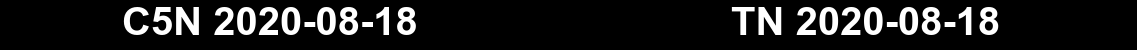

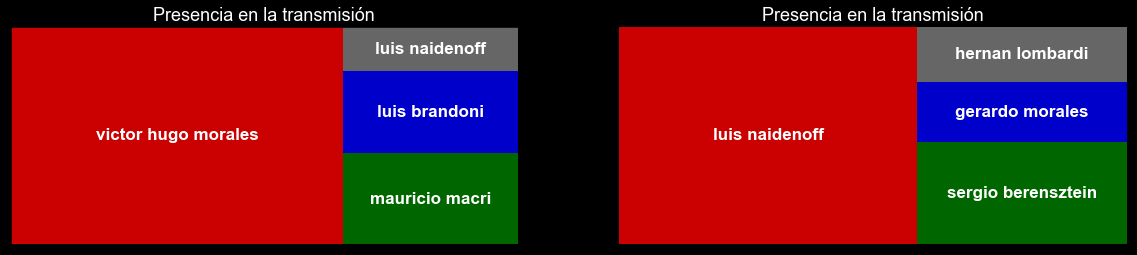

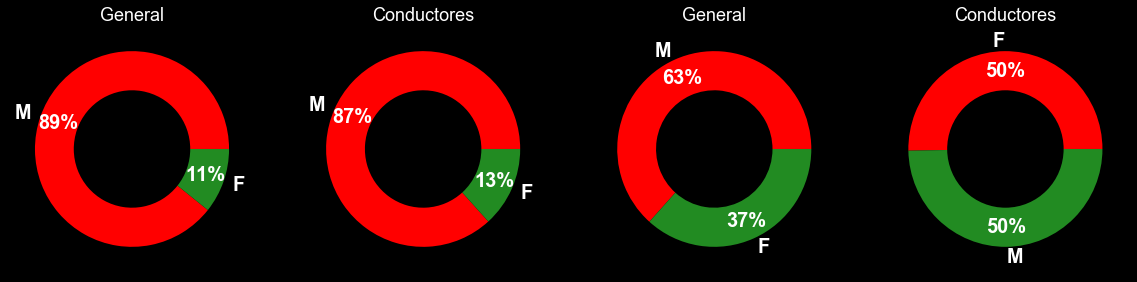

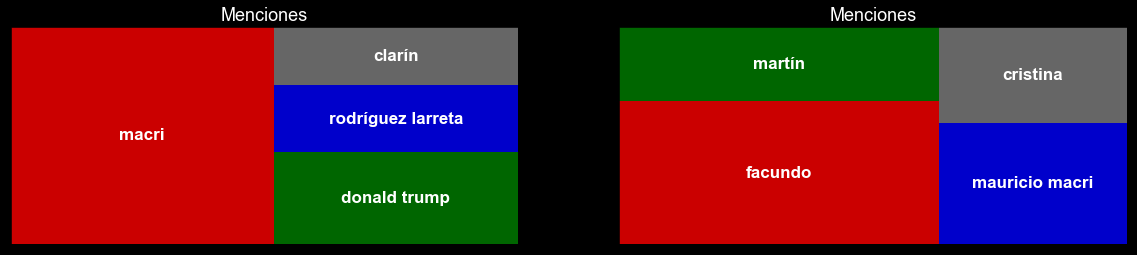

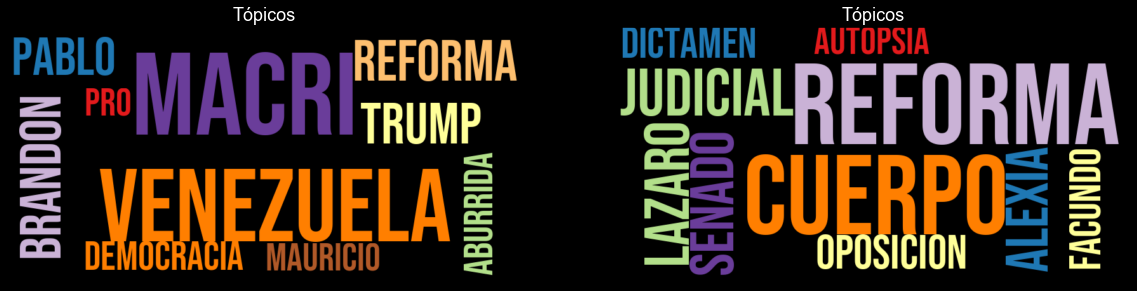

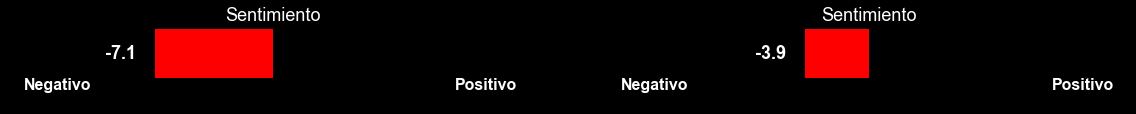

In [43]:
resultadosFileVisual(8,18)